<a href="https://colab.research.google.com/github/dmar10862/uoc_tipologia_y_ciclo_de_vida_de_los_datos_practica_2/blob/develop/src/UOC_M2851_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practica 2: Limpieza y análisis de datos**

M2851 - Tipología y ciclo de vida de los datos

Ciencia de Datos

**David Marín Sánchez**

Junio 2020

**Kaggle Competition**

[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)

# Hyperparametros


In [0]:
dimension_reduction = 0
lr = 0.0002
epochs = 100
patience = 10
batch_size = 1
neurons = 32

# Librerias y funciones

https://github.com/Kaggle/kaggle-api

In [2]:
from google.colab import drive
from google.colab import auth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# ML Model train
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
def train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle=True):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=shuffle, callbacks=[es, mc])

    # load the saved model
    model = load_model('best_model.h5')

    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
  
    # Estimate model performance
    trainScore = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    valScore = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  
    print('Train Loss: %.3f' % trainScore[0])
    print('Train Accuracy: %.3f' % trainScore[1])
    print('Val Loss: %.3f' % valScore[0])
    print('Val Accuracy: %.3f' % valScore[1])
  
    return model

In [0]:
# Entrenar Red neuronal densa
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.kaggle.com/parthsuresh/binary-classifier-using-keras-97-98-accuracy
# @tf.function
def dense_nn(X, y, epochs, batch_size, lr, patience, neurons, shuffle=True): 
  # Split test y val
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

  # Dimensiones
  n_input =  X_train.shape[1]
  n_output = y_train.shape[1]
  
  model = Sequential([
      Dense(n_input, input_dim=n_input, activation='relu'),
      Dense(neurons, activation='relu'),
      Dense(n_output, activation='sigmoid')
  ])
  
  model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

  model = train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle)
  
  return model

In [0]:
# ML Model predict
def predict_with_ml_model(model, X, batch_size):
  y_pred = (model.predict(X, batch_size=batch_size) > 0.5).astype("int32")

  return y_pred

# Descargar dataset de Kaggle

In [6]:
# Montar Google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
%%bash
# Instalar kaggle
pip install -q kaggle

# Cargar las credeciales de Kaggle
mkdir -p /root/.kaggle
cp -a "/content/drive/My Drive/Credentials/kaggle.json" /root/.kaggle/kaggle.json
ls -l /root/.kaggle

total 4
-rw------- 1 root root 64 May  9 08:42 kaggle.json


In [8]:
# Descargar dataset
%%bash
mkdir -p datasets
cd datasets
kaggle competitions download -c titanic
ls -la




total 100
drwxr-xr-x 2 root root  4096 May 17 10:57 .
drwxr-xr-x 1 root root  4096 May 17 10:57 ..
-rw-r--r-- 1 root root  3258 May 17 10:57 gender_submission.csv
-rw-r--r-- 1 root root 28629 May 17 10:57 test.csv
-rw-r--r-- 1 root root 61194 May 17 10:57 train.csv


100%|##########| 3.18k/3.18k [00:00<00:00, 5.69MB/s]
100%|##########| 59.8k/59.8k [00:00<00:00, 61.9MB/s]
100%|##########| 28.0k/28.0k [00:00<00:00, 29.3MB/s]


# Cargar Datos

In [9]:
# Cargar dataset como Pandas DataFrame
df_train = pd.read_csv('datasets/train.csv', index_col = 'PassengerId') 
display(df_train.shape)
display(df_train.head())

(891, 11)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Separar las caracteristicas de la variable a estimar
X_train = df_train.copy()
y_train = X_train[['Survived']]
X_train = X_train.drop(columns=['Survived'])

display(X_train.shape)
display(X_train.head())
display(y_train.shape)
display(y_train.head())

(891, 10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 1)

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [11]:
# Cargar dataset de test
df_test = pd.read_csv('datasets/test.csv', index_col='PassengerId') 
X_test = df_test.copy()
display(X_test.shape)
display(X_test.head())

(418, 10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Limpieza de datos

## Factorizar (de categorias a numeros)

In [12]:
# Convertir variables en numéricas
X_train['Sex'], sex = pd.factorize(X_train['Sex'])
X_train['Embarked'], embarked = pd.factorize(X_train['Embarked'])

sex = {k:v for v, k in enumerate(sex)}
embarked = {k:v for v, k in enumerate(embarked)}

print(sex)
print(embarked)

display(X_train.head())
display(X_train.describe())

{'male': 0, 'female': 1}
{'S': 0, 'C': 1, 'Q': 2}


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
5,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.359147
std,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.638707
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000
25%,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [13]:
X_test['Sex'] = X_test['Sex'].map(sex)
X_test['Embarked'] = X_test['Embarked'].map(embarked)

display(X_test.head())
display(X_test.describe())

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2
893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0
894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2
895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,2.265550,0.363636,30.272590,0.447368,0.392344,35.627188,0.464115
std,0.841838,0.481622,14.181209,0.896760,0.981429,55.907576,0.685516
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.500000,1.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000


## Extraer nuevas carcaterísticas (Fetature Engineering)

In [14]:
# https://www.kaggle.com/ouyangg/titanic
X_train['Title'] = X_train['Name'].str.extract('([A-Za-z]+)\.')
X_train['Title'], title = pd.factorize(X_train['Title'])

title = {k:v for v, k in enumerate(title)}

print(title)
display(X_train.head())
display(X_train.describe())

{'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Don': 4, 'Rev': 5, 'Dr': 6, 'Mme': 7, 'Ms': 8, 'Major': 9, 'Lady': 10, 'Sir': 11, 'Mlle': 12, 'Col': 13, 'Capt': 14, 'Countess': 15, 'Jonkheer': 16}


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1
5,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.359147,0.936027
std,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.638707,1.725341
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,16.000000


In [15]:
X_test['Title'] = X_test['Name'].str.extract('([A-Za-z]+)\.')
X_test['Title'] = X_test['Title'].map(title)

display(X_test.head())
display(X_test.describe())

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2,0.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0,1.0
894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2,0.0
895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0,0.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0,1.0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000,417.000000
mean,2.265550,0.363636,30.272590,0.447368,0.392344,35.627188,0.464115,0.817746
std,0.841838,0.481622,14.181209,0.896760,0.981429,55.907576,0.685516,1.371191
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.500000,1.000000,2.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000,13.000000


## Eliminación de características

In [0]:
# Deajar solo variables Numéricas
X_train = X_train.drop(columns=['Name', 'Ticket', 'Cabin'])
X_test = X_test.drop(columns=['Name', 'Ticket', 'Cabin'])

## Valores perdidos

In [17]:
# https://scikit-learn.org/stable/modules/impute.html
# https://scikit-learn.org/dev/modules/generated/sklearn.impute.KNNImputer.html

# Se asigna a la variable imp un objeto del tipo KNNImputer
imp = KNNImputer().fit(X_train)

# Se aplica la transformación para cada atributo
X_train = pd.DataFrame(imp.transform(X_train), columns = X_train.columns)

# Se analiza la distribución del dataframe
display(X_train.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.834929,0.523008,0.381594,32.204208,0.359147,0.936027
std,0.836071,0.477990,13.534761,1.102743,0.806057,49.693429,0.638707,1.725341
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,2.000000,0.000000,21.100000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,3.000000,0.000000,29.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,1.000000,37.500000,1.000000,0.000000,31.000000,1.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,16.000000


In [18]:
# Se aplica la transformación para cada atributo
X_test = pd.DataFrame(imp.transform(X_test), columns = X_test.columns)

# Se analiza la distribución del dataframe
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.363636,30.284455,0.447368,0.392344,35.561067,0.464115,0.819139
std,0.841838,0.481622,13.303006,0.896760,0.981429,55.856862,0.685516,1.369842
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,3.000000,0.000000,28.550000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.471875,1.000000,1.850000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000,13.000000


# Análisis descriptivo

## Análisis de normalidad y homogeneidad de la varianza y valores extremos

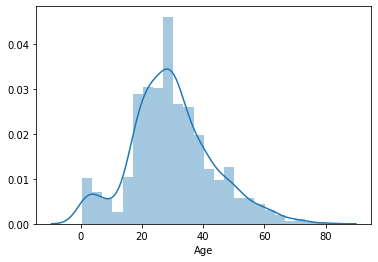

In [19]:
# Age
plot = sns.distplot(X_train['Age']);

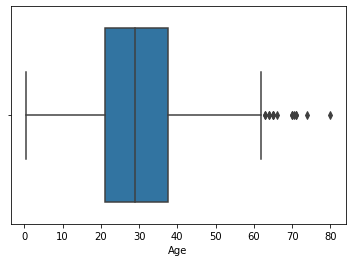

In [20]:
plot = sns.boxplot(X_train['Age']);

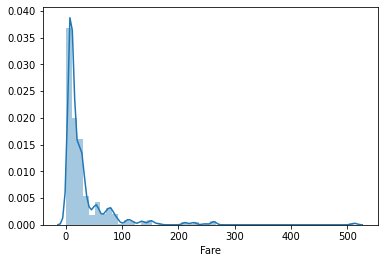

In [21]:
plot = sns.distplot(X_train['Fare']);

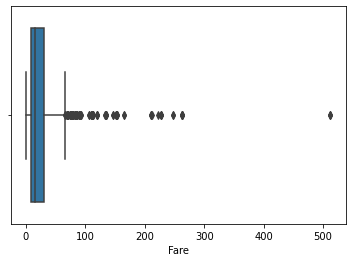

In [22]:
plot = sns.boxplot(X_train['Fare']);

## Análisis de correlación

In [0]:
# Volver a unir las características con la clase a predecir
Xy_train = X_train.copy()
Xy_train['Survived'] = y_train

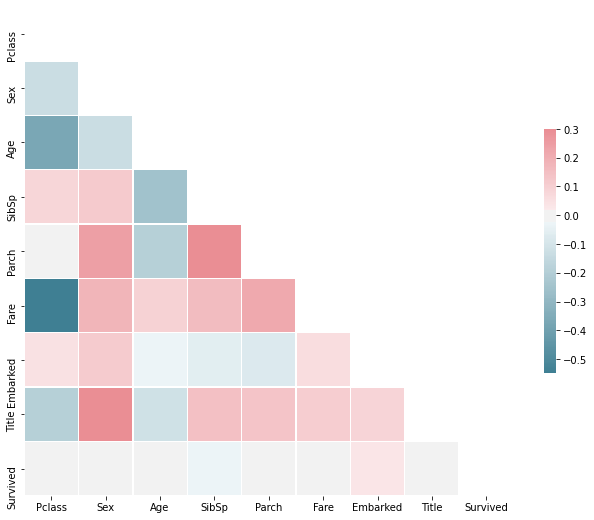

In [24]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = Xy_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Reducción de la dimensionalidad

Proporción de la variabilidad explicada por elos componentes: [0.92957, 0.06832, 0.00112, 0.00046, 0.00018, 0.00017, 0.00012, 7e-05]


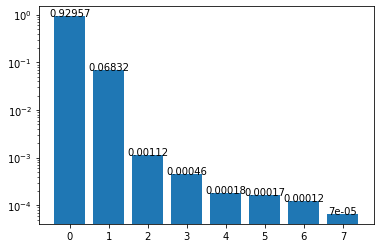

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components = len(X_train.columns)).fit(X_train)

# A) Proporción de la variabilidad explicada por el primer componente
print('Proporción de la variabilidad explicada por elos componentes: ' +
      str([round(value, 5) for value in pca.explained_variance_ratio_]))

# B) Diagrama de barras que representa la proporción de variabilidad explicada
# por los tres componentes más significativos

# Se genera una nueva figura
fig, ax = plt.subplots()
# Se representa el eje y en escala logarítmica para apreciar mejor la
# proporción de variabilidad explicada por los componentes menos significativos
ax.set_yscale('log')
# Se genera una gráfica de barras 
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
# Se añade una etiqueta con el valor de la proporción de variabilidad explicada
for i, value in enumerate(pca.explained_variance_ratio_):
    plt.text(i, value, round(value,5), ha='center')
# Se muestra la gráfica
plt.show()

# Análisis predictivo

## Preparación de los datos

### Reducir dimensiones (si aplica)

In [0]:
if dimension_reduction > 0:
  pca = PCA(n_components = len(X_train.columns) - dimension_reduction).fit(X_train)
  X_train = pd.DataFrame(pca.transform(X_train))

  display(X_train.describe())

In [0]:
if dimension_reduction > 0:
  X_test = pd.DataFrame(pca.transform(X_test))
  display(X_test.describe())

### Estandarización

In [28]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
display(X_train.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.031048e-16,3.162453e-16,2.610457e-17,3.456519e-16,6.716164e-17,-4.373606e-17,1.171279e-16,2.367479e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-7.376951e-01,-2.174508e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-2.129160e+00,-5.428218e-01
25%,-3.693648e-01,-7.376951e-01,-6.457325e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-5.626187e-01,-5.428218e-01
50%,8.273772e-01,-7.376951e-01,-6.172242e-02,-4.745452e-01,-4.736736e-01,-3.573909e-01,-5.626187e-01,-5.428218e-01
75%,8.273772e-01,1.355574e+00,5.666429e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,1.003923e+00,6.170204e-01
max,8.273772e-01,1.355574e+00,3.708469e+00,6.784163e+00,6.974147e+00,9.667167e+00,2.570464e+00,8.735916e+00


In [29]:
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,-0.051570,0.023493,0.033231,-0.068631,0.013345,0.067589,0.164436,-0.067786
std,1.007462,1.008165,0.983429,0.813665,1.218251,1.124660,1.073889,0.794400
min,-1.566107,-0.737695,-2.192990,-0.474545,-0.473674,-0.648422,-0.562619,-0.542822
25%,-1.566107,-0.737695,-0.579200,-0.474545,-0.473674,-0.489442,-0.562619,-0.542822
50%,0.827377,-0.737695,-0.094989,-0.474545,-0.473674,-0.357391,-0.562619,-0.542822
75%,0.827377,1.355574,0.677531,0.432793,-0.473674,-0.014745,1.003923,0.530032
max,0.827377,1.355574,3.412768,6.784163,10.698058,9.667167,2.570464,6.996152


## Modelado

Epoch 1/100
801/801 [==============================] - 1s 1ms/step - loss: 0.6546 - accuracy: 0.6517 - val_loss: 0.5948 - val_accuracy: 0.7222
Epoch 2/100
801/801 [==============================] - 1s 1ms/step - loss: 0.5476 - accuracy: 0.7965 - val_loss: 0.5281 - val_accuracy: 0.7889
Epoch 3/100
801/801 [==============================] - 1s 1ms/step - loss: 0.4838 - accuracy: 0.8077 - val_loss: 0.4949 - val_accuracy: 0.7778
Epoch 4/100
801/801 [==============================] - 1s 1ms/step - loss: 0.4553 - accuracy: 0.8102 - val_loss: 0.4800 - val_accuracy: 0.7667
Epoch 5/100
801/801 [==============================] - 1s 1ms/step - loss: 0.4433 - accuracy: 0.8077 - val_loss: 0.4700 - val_accuracy: 0.7667
Epoch 6/100
801/801 [==============================] - 1s 1ms/step - loss: 0.4376 - accuracy: 0.8077 - val_loss: 0.4640 - val_accuracy: 0.7667
Epoch 7/100
801/801 [==============================] - 1s 1ms/step - loss: 0.4341 - accuracy: 0.8090 - val_loss: 0.4572 - val_accuracy: 0.7667

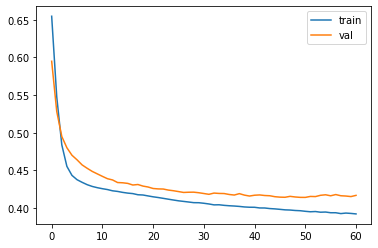

Train Loss: 0.393
Train Accuracy: 0.840
Val Loss: 0.414
Val Accuracy: 0.833


In [30]:
model = dense_nn(X_train, y_train, epochs=epochs, batch_size=batch_size, lr=lr, patience=patience, neurons=neurons)

In [31]:
# accuracy
y_pred = predict_with_ml_model(model, X_train, batch_size=batch_size)
train_acc = accuracy_score(y_train, y_pred, normalize=True)
cmatrix_train = confusion_matrix(y_train, y_pred)

print('Accuracy: %.3f' % train_acc)
print(cmatrix_train)

Accuracy: 0.840
[[498  51]
 [ 92 250]]


In [32]:
# generate predictions for test
df_pred = pd.DataFrame(predict_with_ml_model(model, X_test, batch_size=batch_size), columns=['Survived'], index =  df_test.index)
  
display(df_pred.describe())
display(df_pred.head()) 
df_pred.to_csv('submission.csv', index=True)  

,Survived
count,418.000000
mean,0.370813
std,0.483601
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [33]:
%%bash
kaggle competitions submit -c titanic -f submission.csv -m "New submission test"

Successfully submitted to Titanic: Machine Learning from Disaster

100%|##########| 2.77k/2.77k [00:08<00:00, 335B/s]
